# Baseline Model

## Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
from math import pi
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from itertools import product

In [2]:
#navigating to properfile
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/deeplearning/project/nba_game_data' #MODIFY THIS PATH FOR YOUR OWN DEVICE
os.chdir(path)
os.path.abspath(os.getcwd())

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/deeplearning/project/nba_game_data'

In [3]:
games_details = pd.read_csv('games_details.csv')
players = pd.read_csv('players.csv')
teams = pd.read_csv('teams.csv')
ranking = pd.read_csv('ranking.csv')
games  = pd.read_csv('games_with_sentiment.csv')

<ipython-input-3-2d7ab1a0b950>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  games_details = pd.read_csv('games_details.csv')


In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/deeplearning/project/results' #MODIFY THIS PATH FOR YOUR OWN DEVICE
os.chdir(path)
os.path.abspath(os.getcwd())

'/content/drive/MyDrive/Colab Notebooks/deeplearning/project/results'

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras import optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense,Activation, LSTM, Dropout, TimeDistributed, Flatten, BatchNormalization
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from sklearn.utils import class_weight
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Data Exploration

In [6]:
games_details.shape

(668628, 29)

In [7]:
games_details.head()

,GAME_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_CITY,PLAYER_ID,PLAYER_NAME,NICKNAME,START_POSITION,COMMENT,MIN,...,OREB,DREB,REB,AST,STL,BLK,TO,PF,PTS,PLUS_MINUS
0,22200477,1610612759,SAS,San Antonio,1629641,Romeo Langford,Romeo,F,NaN,18:06,...,1.0,1.0,2.0,0.0,1.0,0.0,2.0,5.0,2.0,-2.0
1,22200477,1610612759,SAS,San Antonio,1631110,Jeremy Sochan,Jeremy,F,NaN,31:01,...,6.0,3.0,9.0,6.0,1.0,0.0,2.0,1.0,23.0,-14.0
2,22200477,1610612759,SAS,San Antonio,1627751,Jakob Poeltl,Jakob,C,NaN,21:42,...,1.0,3.0,4.0,1.0,1.0,0.0,2.0,4.0,13.0,-4.0
3,22200477,1610612759,SAS,San Antonio,1630170,Devin Vassell,Devin,G,NaN,30:20,...,0.0,9.0,9.0,5.0,3.0,0.0,2.0,1.0,10.0,-18.0
4,22200477,1610612759,SAS,San Antonio,1630200,Tre Jones,Tre,G,NaN,27:44,...,0.0,2.0,2.0,3.0,0.0,0.0,2.0,2.0,19.0,0.0


In [8]:
players.shape

(7228, 4)

In [9]:
players.head()

,PLAYER_NAME,TEAM_ID,PLAYER_ID,SEASON
0,Royce O'Neale,1610612762,1626220,2019
1,Bojan Bogdanovic,1610612762,202711,2019
2,Rudy Gobert,1610612762,203497,2019
3,Donovan Mitchell,1610612762,1628378,2019
4,Mike Conley,1610612762,201144,2019


In [10]:
teams.shape

(30, 14)

In [11]:
teams.head(30)

,LEAGUE_ID,TEAM_ID,MIN_YEAR,MAX_YEAR,ABBREVIATION,NICKNAME,YEARFOUNDED,CITY,ARENA,ARENACAPACITY,OWNER,GENERALMANAGER,HEADCOACH,DLEAGUEAFFILIATION
0,0,1610612737,1949,2019,ATL,Hawks,1949,Atlanta,State Farm Arena,18729.0,Tony Ressler,Travis Schlenk,Lloyd Pierce,Erie Bayhawks
1,0,1610612738,1946,2019,BOS,Celtics,1946,Boston,TD Garden,18624.0,Wyc Grousbeck,Danny Ainge,Brad Stevens,Maine Red Claws
2,0,1610612740,2002,2019,NOP,Pelicans,2002,New Orleans,Smoothie King Center,NaN,Tom Benson,Trajan Langdon,Alvin Gentry,No Affiliate
3,0,1610612741,1966,2019,CHI,Bulls,1966,Chicago,United Center,21711.0,Jerry Reinsdorf,Gar Forman,Jim Boylen,Windy City Bulls
4,0,1610612742,1980,2019,DAL,Mavericks,1980,Dallas,American Airlines Center,19200.0,Mark Cuban,Donnie Nelson,Rick Carlisle,Texas Legends
5,0,1610612743,1976,2019,DEN,Nuggets,1976,Denver,Pepsi Center,19099.0,Stan Kroenke,Tim Connelly,Michael Malone,No Affiliate
6,0,1610612745,1967,2019,HOU,Rockets,1967,Houston,Toyota Center,18104.0,Tilman Fertitta,Daryl Morey,Mike D'Antoni,Rio Grande Valley Vipers
7,0,1610612746,1970,2019,LAC,Clippers,1970,Los Angeles,Staples Center,19060.0,Steve Ballmer,Michael Winger,Doc Rivers,Agua Caliente Clippers of Ontario
8,0,1610612747,1948,2019,LAL,Lakers,1948,Los Angeles,Staples Center,19060.0,Jerry Buss Family Trust,Rob Pelinka,Frank Vogel,South Bay Lakers
9,0,1610612748,1988,2019,MIA,Heat,1988,Miami,AmericanAirlines Arena,19600.0,Micky Arison,Pat Riley,Erik Spoelstra,Sioux Falls Skyforce


In [12]:
ranking.shape

(210342, 13)

In [13]:
ranking.head()

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
0,1610612743,0,22022,2022-12-22,West,Denver,30,19,11,0.633,10-3,9-8,NaN
1,1610612763,0,22022,2022-12-22,West,Memphis,30,19,11,0.633,13-2,6-9,NaN
2,1610612740,0,22022,2022-12-22,West,New Orleans,31,19,12,0.613,13-4,6-8,NaN
3,1610612756,0,22022,2022-12-22,West,Phoenix,32,19,13,0.594,14-4,5-9,NaN
4,1610612746,0,22022,2022-12-22,West,LA Clippers,33,19,14,0.576,11-7,8-7,NaN


In [14]:
ranking['STANDINGSDATE'].unique

<bound method Series.unique of 0         2022-12-22
1         2022-12-22
2         2022-12-22
3         2022-12-22
4         2022-12-22
             ...    
210337    2014-09-01
210338    2014-09-01
210339    2014-09-01
210340    2014-09-01
210341    2014-09-01
Name: STANDINGSDATE, Length: 210342, dtype: object>

In [15]:
ranking.loc[ranking['STANDINGSDATE'].str[0:4] == '2022'].loc[ranking['TEAM_ID'] == 1610612743].sort_values(by=['STANDINGSDATE'],ascending=True,)

,TEAM_ID,LEAGUE_ID,SEASON_ID,STANDINGSDATE,CONFERENCE,TEAM,G,W,L,W_PCT,HOME_RECORD,ROAD_RECORD,RETURNTOPLAY
9604,1610612743,0,22021,2022-01-01,West,Denver,34,18,16,0.529,8-6,10-10,NaN
9589,1610612743,0,22021,2022-01-02,West,Denver,34,18,16,0.529,8-6,10-10,NaN
9575,1610612743,0,22021,2022-01-03,West,Denver,35,18,17,0.514,8-6,10-11,NaN
9560,1610612743,0,22021,2022-01-04,West,Denver,35,18,17,0.514,8-6,10-11,NaN
9547,1610612743,0,22021,2022-01-05,West,Denver,36,18,18,0.500,8-7,10-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,1610612743,0,22022,2022-12-18,West,Denver,29,18,11,0.621,9-3,9-8,NaN
46,1610612743,0,22022,2022-12-19,West,Denver,29,18,11,0.621,9-3,9-8,NaN
30,1610612743,0,22022,2022-12-20,West,Denver,30,19,11,0.633,10-3,9-8,NaN
15,1610612743,0,22022,2022-12-21,West,Denver,30,19,11,0.633,10-3,9-8,NaN


In [16]:
games.shape

(26651, 28)

In [17]:
list(games.columns)

['GAME_DATE_EST',
 'GAME_ID',
 'HOME_TEAM_ID',
 'VISITOR_TEAM_ID',
 'SEASON',
 'PTS_home',
 'FG_PCT_home',
 'FT_PCT_home',
 'FG3_PCT_home',
 'AST_home',
 'REB_home',
 'TEAM_ID_away',
 'PTS_away',
 'FG_PCT_away',
 'FT_PCT_away',
 'FG3_PCT_away',
 'AST_away',
 'REB_away',
 'HOME_TEAM_WINS',
 'HOME_TEAM_NAME',
 'VISITOR_TEAM_NAME',
 'year_month',
 'negative %_x',
 'neutral %_x',
 'positive %_x',
 'negative %_y',
 'neutral %_y',
 'positive %_y']

In [18]:
games

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,HOME_TEAM_WINS,HOME_TEAM_NAME,VISITOR_TEAM_NAME,year_month,negative %_x,neutral %_x,positive %_x,negative %_y,neutral %_y,positive %_y
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,...,1,New OrleansPelicans,San AntonioSpurs,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,...,1,UtahJazz,WashingtonWizards,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,...,1,ClevelandCavaliers,MilwaukeeBucks,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,...,1,Philadelphia76ers,DetroitPistons,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,...,0,AtlantaHawks,ChicagoBulls,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26646,2014-10-06,11400007,1610612737,1610612740,2014,93.0,0.419,0.821,0.421,24.0,...,1,AtlantaHawks,New OrleansPelicans,2014-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
26647,2014-10-06,11400004,1610612741,1610612764,2014,81.0,0.338,0.719,0.381,18.0,...,0,ChicagoBulls,WashingtonWizards,2014-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
26648,2014-10-06,11400005,1610612747,1610612743,2014,98.0,0.448,0.682,0.500,29.0,...,1,Los AngelesLakers,DenverNuggets,2014-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
26649,2014-10-05,11400002,1610612761,1610612758,2014,99.0,0.440,0.771,0.333,21.0,...,1,TorontoRaptors,SacramentoKings,2014-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273


## Data Preparation

In [19]:
# selected_features = list(games.columns)
# to_drop = ['GAME_STATUS_TEXT','TEAM_ID_home']
# for var in to_drop:
#   selected_features.remove(var)

ValueError: ignored

In [ ]:
# games = games[selected_features]

In [20]:
games.head()

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,HOME_TEAM_WINS,HOME_TEAM_NAME,VISITOR_TEAM_NAME,year_month,negative %_x,neutral %_x,positive %_x,negative %_y,neutral %_y,positive %_y
0,2022-12-22,22200477,1610612740,1610612759,2022,126.0,0.484,0.926,0.382,25.0,...,1,New OrleansPelicans,San AntonioSpurs,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
1,2022-12-22,22200478,1610612762,1610612764,2022,120.0,0.488,0.952,0.457,16.0,...,1,UtahJazz,WashingtonWizards,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
2,2022-12-21,22200466,1610612739,1610612749,2022,114.0,0.482,0.786,0.313,22.0,...,1,ClevelandCavaliers,MilwaukeeBucks,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
3,2022-12-21,22200467,1610612755,1610612765,2022,113.0,0.441,0.909,0.297,27.0,...,1,Philadelphia76ers,DetroitPistons,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
4,2022-12-21,22200468,1610612737,1610612741,2022,108.0,0.429,1.000,0.378,22.0,...,0,AtlantaHawks,ChicagoBulls,2022-12,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273


In [21]:
games.loc[((games["HOME_TEAM_ID"] == 1610612748) | (games["VISITOR_TEAM_ID"] == 1610612748))].loc[games['SEASON'] == 2021]

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,...,HOME_TEAM_WINS,HOME_TEAM_NAME,VISITOR_TEAM_NAME,year_month,negative %_x,neutral %_x,positive %_x,negative %_y,neutral %_y,positive %_y
548,2022-05-29,42100307,1610612748,1610612738,2021,96.0,0.420,0.667,0.200,16.0,...,0,MiamiHeat,BostonCeltics,2022-05,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
549,2022-05-27,42100306,1610612738,1610612748,2021,103.0,0.444,0.903,0.333,22.0,...,0,BostonCeltics,MiamiHeat,2022-05,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
551,2022-05-25,42100305,1610612748,1610612738,2021,80.0,0.319,0.929,0.156,14.0,...,0,MiamiHeat,BostonCeltics,2022-05,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
553,2022-05-23,42100304,1610612738,1610612748,2021,102.0,0.397,0.842,0.235,21.0,...,1,BostonCeltics,MiamiHeat,2022-05,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
555,2022-05-21,42100303,1610612738,1610612748,2021,103.0,0.486,0.767,0.375,21.0,...,0,BostonCeltics,MiamiHeat,2022-05,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2021-10-14,12100055,1610612737,1610612748,2021,127.0,0.485,0.769,0.413,33.0,...,1,AtlantaHawks,MiamiHeat,2021-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
1887,2021-10-11,12100040,1610612748,1610612766,2021,104.0,0.419,0.667,0.333,23.0,...,1,MiamiHeat,CharlotteHornets,2021-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
1904,2021-10-08,12100029,1610612759,1610612748,2021,105.0,0.455,0.684,0.333,28.0,...,0,San AntonioSpurs,MiamiHeat,2021-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273
1909,2021-10-07,12100024,1610612745,1610612748,2021,106.0,0.409,0.697,0.297,22.0,...,0,HoustonRockets,MiamiHeat,2021-10,13.760926,53.310051,32.929024,13.85407,53.055657,33.090273


In [22]:
games.loc[((games["HOME_TEAM_ID"] == 1610612748) | (games["VISITOR_TEAM_ID"] == 1610612748))]['SEASON'].value_counts()

2012    113
2005    112
2013    110
2010    109
2021    106
2015    104
2019    102
2003    102
2004    100
2008     96
2009     94
2017     93
2006     93
2011     91
2014     90
2016     90
2007     89
2018     88
2020     79
2022     37
Name: SEASON, dtype: int64

Dataset includes playoff games!

In [23]:
#aggregation
YEARS = [i for i in range(2003,2023)]

In [24]:
def data_transformation(games,TEAM_ID,YEAR):
  df = games.loc[((games["HOME_TEAM_ID"] == TEAM_ID)
  | (games["VISITOR_TEAM_ID"] == TEAM_ID))].loc[games['SEASON'] == YEAR]
  df.sort_values(by=['GAME_DATE_EST'],ascending=True,inplace=True)
  df = df[['HOME_TEAM_ID', 'VISITOR_TEAM_ID',
                                              'PTS_home', 'FG_PCT_home',
                                              'FT_PCT_home', 'FG3_PCT_home',
                                              'AST_home', 'REB_home',
                                              'TEAM_ID_away', 'PTS_away',
                                              'FG_PCT_away', 'FT_PCT_away',
                                              'FG3_PCT_away', 'AST_away',
                                              'REB_away', 'HOME_TEAM_WINS']]

  df['OTHER_TEAM_ID'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                                df['VISITOR_TEAM_ID'], df['HOME_TEAM_ID'])
  df['WIN'] = np.where(
      (df['HOME_TEAM_ID'] == TEAM_ID) & (df['HOME_TEAM_WINS'] == 1) |
      (df['HOME_TEAM_ID'] != TEAM_ID) & (df['HOME_TEAM_WINS'] == 0), 1, 0
  )
  # Identify columns with 'home' and 'away' suffixes
  home_columns = df.columns[df.columns.str.endswith('_home')]
  away_columns = df.columns[df.columns.str.endswith('_away')]
  # Create new columns with 'current' suffixes based on conditions
  df['PTS_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                              df['PTS_home'], df['PTS_away'])
  df['FG_PCT_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                                  df['FG_PCT_home'], df['FG_PCT_away'])
  df['FT_PCT_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                                  df['FT_PCT_home'], df['FT_PCT_away'])
  df['FG3_PCT_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                                  df['FG3_PCT_home'], df['FG3_PCT_away'])
  df['AST_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                              df['AST_home'], df['AST_away'])
  df['REB_current'] = np.where(df['HOME_TEAM_ID'] == TEAM_ID,
                              df['REB_home'], df['REB_away'])
  df['PTS_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                df['PTS_home'], df['PTS_away'])
  df['FG_PCT_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                  df['FG_PCT_home'], df['FG_PCT_away'])
  df['FT_PCT_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                  df['FT_PCT_home'], df['FT_PCT_away'])
  df['FG3_PCT_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                    df['FG3_PCT_home'], df['FG3_PCT_away'])
  df['AST_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                df['AST_home'], df['AST_away'])
  df['REB_opposing'] = np.where(df['HOME_TEAM_ID'] != TEAM_ID,
                                df['REB_home'], df['REB_away'])

  df = df.drop(home_columns, axis=1)
  df = df.drop(away_columns, axis=1)
  df.drop(['HOME_TEAM_ID', 'VISITOR_TEAM_ID','HOME_TEAM_WINS'],
          axis=1,inplace=True)
  return df

In [25]:
TEAM_IDS = list(teams['TEAM_ID'].unique())
dfs = [data_transformation(games,combo[0],combo[1])for combo in product(TEAM_IDS,YEARS)]

In [26]:
# df.shape

## Data Modelling

For singular team and year (heat, 2021)

In [27]:
TEAM_ID = 1610612748
YEAR = 2020

In [28]:
df = data_transformation(games,TEAM_ID,YEAR)

In [29]:
# games.loc[((games["HOME_TEAM_ID"] == TEAM_ID)
#   | (games["VISITOR_TEAM_ID"] == TEAM_ID))].loc[games['SEASON'] == YEAR].head(10)

In [30]:
# df.head(10)

In [31]:
# Feature columns
feature_columns = ['PTS_current', 'FG_PCT_current', 'FT_PCT_current',
                   'FG3_PCT_current', 'AST_current', 'REB_current',
                   'PTS_opposing', 'FG_PCT_opposing', 'FT_PCT_opposing',
                   'FG3_PCT_opposing', 'AST_opposing', 'REB_opposing']

# Target column
target_column = 'WIN'

# Function to create sequences
def create_sequences(data, sequence_length):
    sequences = []
    targets = []

    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i+sequence_length][feature_columns].values
        label = data.iloc[i+sequence_length][target_column]
        sequences.append(seq)
        targets.append(label)

    return np.array(sequences), np.array(targets)

# Choose sequence length
sequence_length = 10

# Create sequences and targets
sequences, targets = create_sequences(df, sequence_length)
print(sequences.shape)
print(targets.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=6868)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


(96, 10, 12)
(96,)


In [32]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, len(feature_columns)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               72192     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 72321 (282.50 KB)
Trainable params: 72321 (282.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.7006 - accuracy: 0.3947 - val_loss: 0.6838 - val_accuracy: 0.6000
Epoch 2/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6845 - accuracy: 0.6316 - val_loss: 0.6679 - val_accuracy: 0.6000
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 0.6714 - accuracy: 0.6447 - val_loss: 0.6552 - val_accuracy

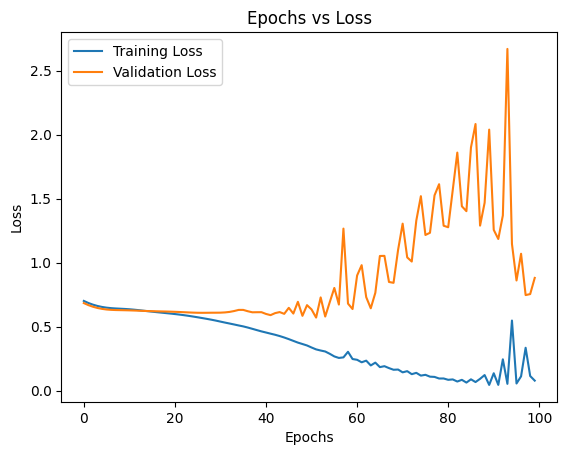

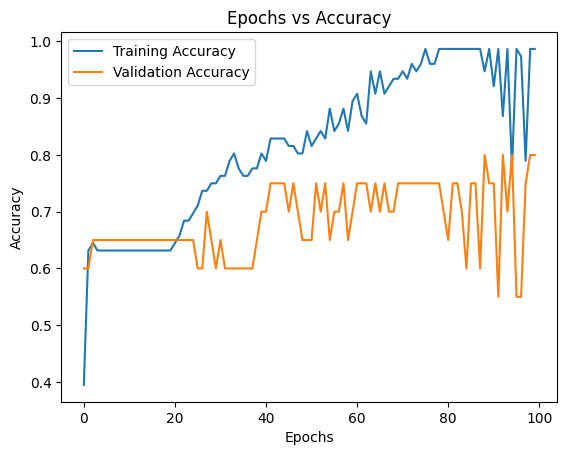

In [33]:
# Save accuracy and loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot epochs vs loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Epochs vs Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot epochs vs accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Epochs vs Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

1/1 [==============================] - 0s 25ms/step - loss: 0.8806 - accuracy: 0.8000
Test Loss: 0.8806, Test Accuracy: 0.8000


### Hyperparameter tuning

In [35]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.3/265.3 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.2-py2.py3-none-any.whl size=265363806 sha256=efea1159b20208ca64abe60884aa95e9a71387b82505da21e16006b90f1fa98b
  Stored in directory: /root/.cache/pip/wheels/e9/ea/ab/889709967692e30c57c46137edd2cae6b2768bb65ec7cb8aa5
Successfully built h2o


In [36]:
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpj3e9twl6
  JVM stdout: /tmp/tmpj3e9twl6/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpj3e9twl6/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_unknownUser_rcj4df
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [37]:
hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [38]:
df.dtypes

OTHER_TEAM_ID         int64
WIN                   int64
PTS_current         float64
FG_PCT_current      float64
FT_PCT_current      float64
FG3_PCT_current     float64
AST_current         float64
REB_current         float64
PTS_opposing        float64
FG_PCT_opposing     float64
FT_PCT_opposing     float64
FG3_PCT_opposing    float64
AST_opposing        float64
REB_opposing        float64
dtype: object

In [39]:
factor = ['OTHER_TEAM_ID',
 'WIN']
numeric = [ 'PTS_current',
 'FG_PCT_current',
 'FT_PCT_current',
 'FG3_PCT_current',
 'AST_current',
 'REB_current',
 'PTS_opposing',
 'FG_PCT_opposing',
 'FT_PCT_opposing',
 'FG3_PCT_opposing',
 'AST_opposing',
 'REB_opposing']

In [40]:
for col in factor:
  before = hf[col].isfactor()
  hf[col] = hf[col].asfactor()
  print(f"before: {before}, after: {hf[col].isfactor()}")

for col in numeric:
  before = hf[col].isnumeric()
  hf[col] = hf[col].asnumeric()
  print(f"before: {before}, after: {hf[col].isnumeric()}")

before: [False], after: [True]
before: [False], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]
before: [True], after: [True]


In [41]:
response="WIN"
predictors=list(hf.columns)
predictors.remove('WIN')
print(predictors)

['OTHER_TEAM_ID', 'PTS_current', 'FG_PCT_current', 'FT_PCT_current', 'FG3_PCT_current', 'AST_current', 'REB_current', 'PTS_opposing', 'FG_PCT_opposing', 'FT_PCT_opposing', 'FG3_PCT_opposing', 'AST_opposing', 'REB_opposing']


In [42]:
train, valid = hf.split_frame(ratios = [.8], seed = 1234)

In [43]:
from h2o.automl import H2OAutoML

In [44]:
hf[response].isfactor()

[True]

In [45]:
# Run AutoML for 10 base models
aml = H2OAutoML(max_models=20, seed=1234)
aml.train(x = predictors,
                   y = response,
                   training_frame = train)

AutoML progress: |█
00:03:08.993: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 82.0.

██████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20231218_00303


GLM Model: summary
    family    link    regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Ridge ( lambda = 0.003085 )  nlambda = 30, lambda.max = 30.847, lambda.min = 0.003085, lambda.1se = 0.0151  41                            40                             60                      AutoML_1_20231218_00303_training_py_44_sid_8e34

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0027796056549167663
RMSE: 0.052721965582826734
LogLoss: 0.02667447042301122
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 81
Residual degrees of freedom: 41
Null deviance: 107.70076691913974
Residual deviance: 4.374613149373836
AIC: 86.37461314937383

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8168881990849645
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      30   0    0        (0.0/30.0)
1      0    52   0        (0.0/52.0)
Total  30   52   0        (0.0/82.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.816888     1         51
max f2                       0.816888     1         51
max f0point5                 0.816888     1         51
max accuracy                 0.816888     1         51
max precision                1            1         0
max recall                   0.816888     1         51
max specificity              1            1         0
max absolute_mcc             0.816888     1         51
max min_per_class_accuracy   0.816888     1         51
max mean_per_class_accuracy  0.816888     1         51
max tns                      1            30        0
max fns                      1            51        0
max fps                      2.1376e-06   30        81
max tps                      0.816888     52        51
max tnr                      1            1         0
max fnr                      1            0.980769  0
max fpr                      2.1376e-06   1         81
max tpr                      0.816888     1         51

Gains/Lift Table: Avg response rate: 63.41 %, avg score: 63.41 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0121951                   0.999999           1.57692   1.57692            1                1           1                           1                   0.0192308       0.0192308                  57.6923   57.6923            0.0192308
2        0.0243902                   0.999999           1.57692   1.57692            1                0.999999    1                           0.999999            0.0192308       0.0384615                  57.6923   57.6923            0.0384615
3        0.0365854                   0.999998           1.57692   1.57692            1                0.999998    1                           0.999999            0.0192308       0.0576923                  57.6923   57.6923            0.0576923
4        0.0487805                   0.999995

In [46]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GLM_1_AutoML_1_20231218_00303,0.995513,0.0925502,0.997482,0.05,0.169319,0.0286688
DeepLearning_grid_1_AutoML_1_20231218_00303_model_1,0.994231,0.143403,0.996766,0.0358974,0.193606,0.0374832
StackedEnsemble_BestOfFamily_1_AutoML_1_20231218_00303,0.992308,0.115465,0.995649,0.0358974,0.185901,0.0345591
StackedEnsemble_AllModels_1_AutoML_1_20231218_00303,0.992308,0.112669,0.995531,0.0429487,0.186201,0.0346709
DeepLearning_grid_3_AutoML_1_20231218_00303_model_1,0.992308,0.146691,0.995751,0.0525641,0.203548,0.0414319
DeepLearning_grid_2_AutoML_1_20231218_00303_model_1,0.990385,0.138041,0.993985,0.0333333,0.196845,0.0387481
XRT_1_AutoML_1_20231218_00303,0.974038,0.284162,0.983487,0.0692308,0.282072,0.0795647
DRF_1_AutoML_1_20231218_00303,0.964423,0.304651,0.978643,0.109615,0.297932,0.0887636
GBM_grid_1_AutoML_1_20231218_00303_model_1,0.960256,0.238629,0.977527,0.0858974,0.276169,0.0762694
XGBoost_3_AutoML_1_20231218_00303,0.952564,0.302974,0.971706,0.116667,0.29852,0.089114


In [47]:
# The leader model is stored here
aml.leader

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20231218_00303


GLM Model: summary
    family    link    regularization               lambda_search                                                                  number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Ridge ( lambda = 0.003085 )  nlambda = 30, lambda.max = 30.847, lambda.min = 0.003085, lambda.1se = 0.0151  41                            40                             60                      AutoML_1_20231218_00303_training_py_44_sid_8e34

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.0027796056549167663
RMSE: 0.052721965582826734
LogLoss: 0.02667447042301122
AUC: 1.0
AUCPR: 1.0
Gini: 1.0
Null degrees of freedom: 81
Residual degrees of freedom: 41
Null deviance: 107.70076691913974
Residual deviance: 4.374613149373836
AIC: 86.37461314937383

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8168881990849645
       0    1    Error    Rate
-----  ---  ---  -------  ----------
0      30   0    0        (0.0/30.0)
1      0    52   0        (0.0/52.0)
Total  30   52   0        (0.0/82.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.816888     1         51
max f2                       0.816888     1         51
max f0point5                 0.816888     1         51
max accuracy                 0.816888     1         51
max precision                1            1         0
max recall                   0.816888     1         51
max specificity              1            1         0
max absolute_mcc             0.816888     1         51
max min_per_class_accuracy   0.816888     1         51
max mean_per_class_accuracy  0.816888     1         51
max tns                      1            30        0
max fns                      1            51        0
max fps                      2.1376e-06   30        81
max tps                      0.816888     52        51
max tnr                      1            1         0
max fnr                      1            0.980769  0
max fpr                      2.1376e-06   1         81
max tpr                      0.816888     1         51

Gains/Lift Table: Avg response rate: 63.41 %, avg score: 63.41 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0121951                   0.999999           1.57692   1.57692            1                1           1                           1                   0.0192308       0.0192308                  57.6923   57.6923            0.0192308
2        0.0243902                   0.999999           1.57692   1.57692            1                0.999999    1                           0.999999            0.0192308       0.0384615                  57.6923   57.6923            0.0384615
3        0.0365854                   0.999998           1.57692   1.57692            1                0.999998    1                           0.999999            0.0192308       0.0576923                  57.6923   57.6923            0.0576923
4        0.0487805                   0.999995

In [48]:
preds = aml.leader.predict(valid)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [49]:
perf = aml.leader.model_performance(valid)
perf.auc()

0.9243697478991597

miami heat all years

In [50]:
df_heat_all_years = [data_transformation(games,TEAM_ID,year) for year in YEARS]

In [51]:
df_heat_all_years[1]

,OTHER_TEAM_ID,WIN,PTS_current,FG_PCT_current,FT_PCT_current,FG3_PCT_current,AST_current,REB_current,PTS_opposing,FG_PCT_opposing,FT_PCT_opposing,FG3_PCT_opposing,AST_opposing,REB_opposing
17898,1610612737,1,113.0,0.582,0.652,0.357,16.0,43.0,82.0,0.403,0.657,0.111,20.0,36.0
17876,1610612766,0,74.0,0.388,0.741,0.200,15.0,36.0,82.0,0.446,0.750,0.571,19.0,41.0
17872,1610612753,0,103.0,0.422,0.690,0.412,21.0,39.0,109.0,0.438,0.721,0.471,18.0,49.0
17852,1610612751,1,100.0,0.507,0.667,0.500,24.0,42.0,77.0,0.378,0.704,0.250,19.0,36.0
17837,1610612739,1,92.0,0.474,0.630,0.273,15.0,41.0,86.0,0.388,0.773,0.231,19.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16555,1610612765,1,113.0,0.523,0.704,0.500,22.0,39.0,104.0,0.439,0.651,0.308,22.0,38.0
16553,1610612765,0,96.0,0.444,0.744,0.214,17.0,38.0,106.0,0.481,0.718,0.500,27.0,39.0
16551,1610612765,1,88.0,0.522,0.565,0.375,17.0,38.0,76.0,0.385,0.650,0.273,16.0,40.0
16550,1610612765,0,66.0,0.406,0.611,0.231,15.0,40.0,91.0,0.419,0.632,0.412,24.0,46.0


In [52]:
# Feature columns
feature_columns = ['PTS_current', 'FG_PCT_current', 'FT_PCT_current',
                   'FG3_PCT_current', 'AST_current', 'REB_current',
                   'PTS_opposing', 'FG_PCT_opposing', 'FT_PCT_opposing',
                   'FG3_PCT_opposing', 'AST_opposing', 'REB_opposing']

# Target column
target_column = 'WIN'

# Function to create sequences
def create_sequences(dataframes, sequence_length):
    sequences = []
    targets = []

    for df in dataframes:
        for i in range(len(df) - sequence_length):
            seq = df.iloc[i:i+sequence_length][feature_columns].values
            label = df.iloc[i+sequence_length][target_column]
            sequences.append(seq)
            targets.append(label)

    return np.array(sequences), np.array(targets)

# Choose sequence length
sequence_length = 10

# Create sequences and targets
sequences, targets = create_sequences(df_heat_all_years, sequence_length)

In [53]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, len(feature_columns)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               72192     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 72321 (282.50 KB)
Trainable params: 72321 (282.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
11/11 [==============================] - 4s 90ms/step - loss: nan - accuracy: 0.4300 - val_loss: nan - val_accuracy: 0.4441
Epoch 2/100
11/11 [==============================] - 0s 39ms/step - loss: nan - accuracy: 0.4212 - val_loss: nan - val_accuracy: 0.4441
Epoch 3/100
11/11 [==============================] - 0s 36ms/step - loss: nan - accuracy: 0.4212 - val_loss: nan - val_accuracy: 0.4441

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

11/11 [==============================] - 0s 4ms/step - loss: nan - accuracy: 0.4441
Test Loss: nan, Test Accuracy: 0.4441


For all teams and years

In [ ]:
# Feature columns
feature_columns = ['PTS_current', 'FG_PCT_current', 'FT_PCT_current',
                   'FG3_PCT_current', 'AST_current', 'REB_current',
                   'PTS_opposing', 'FG_PCT_opposing', 'FT_PCT_opposing',
                   'FG3_PCT_opposing', 'AST_opposing', 'REB_opposing']

# Target column
target_column = 'WIN'

# Function to create sequences
def create_sequences(dataframes, sequence_length):
    sequences = []
    targets = []

    for df in dataframes:
        for i in range(len(df) - sequence_length):
            seq = df.iloc[i:i+sequence_length][feature_columns].values
            label = df.iloc[i+sequence_length][target_column]
            sequences.append(seq)
            targets.append(label)

    return np.array(sequences), np.array(targets)

# Choose sequence length
sequence_length = 10

# Create sequences and targets
sequences, targets = create_sequences(dfs, sequence_length)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(512, input_shape=(sequence_length, len(feature_columns)), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test))

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')